# Dependencies

In [1]:
import cv2
import image_manipulation
from multiprocessing import Pool
from models import *
import numpy as np
import glob
import matplotlib.pyplot as plt
import preprocessing
import json
from os import path, mkdir

import keras
from argparse import ArgumentParser
import tensorflow as tf
from sklearn import metrics

from skimage import exposure
import MURA


2023-06-28 22:15:36.559842: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/clr/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


# Model to Run
This section lets the user edit on what model parameters to run, the model directory and parameters should exist prior to changing the file path

In [3]:
# All editable variables
model_file_path = "models/model_1_UPAE"
# If preprocessing needs to run
run_preprocessing = False

In [4]:
# Get model parameters
try:
    params = json.load(open(model_file_path + '/parameters.json'))

    # Model to use
    model_is_VAE = params['is_VAE']
    # Model parameters
    multiplier = params['multiplier']
    latent_size = params['latent_size']
    input_shape = params['input_shape']

    # Training parameters
    epochs = params['num_epochs']
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']

    # Dataset Path
    # image_paths = MURA.MURA_DATASET()
    dataset_file_path = params['dataset_path']
    # all_image_paths = image_paths.get_combined_image_paths()
    # all_image_paths = all_image_paths.to_numpy()[:,0]
except:
    raise Exception("No parameters.json file found in the model's directory.")

In [5]:
# each array contains the training, validation, and testing in order
image_datasets = {'train': [],
                'valid': [],
                'test': []}
for dataset_name in image_datasets.keys():
    for image_path in glob.glob(f'{dataset_file_path}/{dataset_name}/*.png'):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = exposure.rescale_intensity(image, in_range=(0, 255))
        image_datasets[dataset_name].append(image)
    image_datasets[dataset_name] = np.array(image_datasets[dataset_name])

# Model Training
This section creates and trains the model

In [6]:
if __name__ == "__main__":

    if model_is_VAE:
        model = VAE(False, input_shape, multiplier, latent_size)
    else:
        model = UPAE(True, input_shape, multiplier, latent_size)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.build(input_shape=(None,) + tuple(input_shape))

    model.compile(optimizer= optimizer, loss='mse'
                  ,metrics=[tf.keras.metrics.Accuracy()])
    
    model.summary()
    
    try:
        model.load_weights(model_file_path + "/model_weights")
    except:
        train_data = image_datasets['train']
        validation_data = image_datasets['valid']

        # Where images of each epoch will be saved
        save_directory = model_file_path + '/callback_images'
        save_callback = SaveImageCallback(validation_data, save_directory=save_directory, vae=model_is_VAE)

        EarlyStopping_callback = tf.keras.callbacks.EarlyStopping(monitor='mse_loss', patience=30,
                                                                  restore_best_weights=True)

        history_train = model.fit(train_data 
                                , epochs=epochs
                                , batch_size=batch_size
                                , validation_data=(validation_data, validation_data)
                                , callbacks=[save_callback]
                                )
        
        # Saving the model's history
        json.dump(history_train.history, open(model_file_path + '/history.json', 'w'))

        #Save weights
        model.save_weights(model_file_path + '/model_weights')

/home/clr/miniconda3/envs/tf/lib/python3.9/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "upae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_decoder (encoder_de  multiple                 19490848  
 coder)                                                          
                                                                 
Total params: 19,490,860
Trainable params: 19,480,352
Non-trainable params: 10,508
_________________________________________________________________
Epoch 1/100


2023-06-28 22:15:51.628168: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



49/49 [==============================] - 7s 84ms/step - mse_loss: 6218.3604 - total_loss: 162.7967 - loss1: 107.3968 - loss2: 55.3998 - reconstruction_loss: -336.5882 - accuracy: 0.0456 - val_mse_loss: 3243.9717 - val_total_loss: 25.4659 - val_loss1: 0.0764 - val_loss2: 25.3896 - val_reconstruction_loss: -738.1328 - val_accuracy: 0.0026
Epoch 2/100
49/49 [==============================] - 3s 51ms/step - mse_loss: 2555.2285 - total_loss: 15.8251 - loss1: 2.6108 - loss2: 13.2143 - reconstruction_loss: -502.3614 - accuracy: 0.0029 - val_mse_loss: 3817.6982 - val_total_loss: 14.1421 - val_loss1: 1.3826 - val_loss2: 12.7595 - val_reconstruction_loss: -738.8656 - val_accuracy: 0.0014
Epoch 3/100
49/49 [==============================] - 3s 63ms/step - mse_loss: 2550.0359 - total_loss: 13.6260 - loss1: 2.2277 - loss2: 11.3983 - reconstruction_loss: -495.6084 - accuracy: 9.6246e-04 - val_mse_loss: 3889.1858 - val_total_loss: 13.4979 - val_loss1: 3.3102 - val_loss2: 10.1877 - val_reconstruction_

# Plots Creation

In [7]:
# Create directory for saving images
save_directory = model_file_path + '/plots'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)


In [8]:
# Get history of data
history = history_train.history

def create_plot(history, metric, title, save_name):
    plt.plot(history[metric], label=metric)
    plt.plot(history[f'val_{metric}'], label=f'val_{metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(title)
    plt.legend()
    plt.savefig(f'{save_directory}/{save_name}', dpi=300)
    plt.close()

# Check if UPAE or not
if model_is_VAE:
    # Create plot for mse_loss
    create_plot(history, 'mse_loss', 'MSE Loss per Epoch', 'mse_loss.png')
    # Create plot for reconstruction_loss
    create_plot(history, 'reconstruction_loss', 'Reconstruction Loss per Epoch', 'reconstruction_loss.png')
    # Create plot for kl_loss
    create_plot(history, 'kl_loss', 'KL Loss per Epoch', 'kl_loss.png')
else:
    # Create plot for mse_loss
    create_plot(history, 'mse_loss', 'MSE Loss per Epoch', 'mse_loss.png')
    # Create plot for total loss
    create_plot(history, 'total_loss', 'Total Loss per Epoch', 'total_loss.png')
    # Create plot for loss1
    create_plot(history, 'loss1', 'Loss 1 per Epoch', 'loss1.png')
    # Create plot for loss2
    create_plot(history, 'loss2', 'Loss 2 per Epoch', 'loss2.png')
    # Create plot for binary_crossentropy
#     create_plot(history, 'reconstruction_loss', 'Reconstruction Loss per Epoch', 'reconstruction_loss.png')
#     # Create plot for accuracy
#     create_plot(history, 'accuracy', 'Accuracy per Epoch', 'accuracy.png')
    

# Testing of the Model with the Test Set (CARA VERSION)
This section tests the model with the current test set
TODO: 
- Get the label of each image in the test set
- Test the images
- Create Linear Regression for the abnormality score to get the threshold for determining abnormal or normal images

In [13]:
test_images = []
labels = []
for image_path in glob.glob(f'{dataset_file_path}/test/*.png'):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Get if it contains positive or negative
    if 'positive' in image_path:
        test_images.append(image)
        labels.append(1)
    else:
        test_images.append(image)
        labels.append(0)
test_images = np.array(test_images)

In [14]:
history_valid = model.predict(image_datasets['test'], batch_size=batch_size)

In [15]:
abnor_scores = history_valid[1]
#converting to an array of numbers instead of tensor
abnor_scores = [item.numpy() for item in abnor_scores if isinstance(item, tf.Tensor)]
abnor_scores = [float(item) for item in abnor_scores]

In [16]:
fpr, tpr, thresholds = metrics.roc_curve(labels, abnor_scores)
idx = None
for i in range(len(fpr)):
    fnr = 1 - tpr[i]
    if abs(fpr[i] - fnr) <= 5e-3:
        idx = i
        break
assert idx is not None

t = thresholds[idx]
y_pred = np.zeros_like(labels)
y_pred[abnor_scores < t] = 0
y_pred[abnor_scores >= t] = 1
pres = metrics.precision_score(labels, y_pred)
sens = metrics.recall_score(labels, y_pred, pos_label=1)
spec = metrics.recall_score(labels, y_pred, pos_label=0)
f1 = metrics.f1_score(labels, y_pred)
print('Error rate:{}'.format(fpr[idx]))
print('Precision:{} Sensitivity:{} Specificity:{} f1:{}\n'.format(
    pres, sens, spec, f1))

AssertionError: 

In [17]:
auc = metrics.roc_auc_score(labels, y_pred)

# Plot the ROC curve
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig(model_file_path+'/plots/roc_curve.png')



#ROC AUC Curve interpretation
# https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/


NameError: name 'y_pred' is not defined

## Getting variance image output from testing

In [ ]:
history_valid[3]

In [9]:
#variance from testing set
variance_tensor = history_valid[2][8]
variance_array = variance_tensor.numpy()
# Normalize the values between 0 and 1
normalized_array = (variance_array - np.min(variance_array)) / (np.max(variance_array) - np.min(variance_array))
# Scale the values to the range of pixel values (0-255)
scaled_array = (normalized_array * 255).astype(np.uint8)

plt.imshow(scaled_array, cmap='gray')
plt.axis('off')
plt.show()

NameError: name 'history_valid' is not defined

In [19]:
#history_valid[2] is the variance from the test set
image = history_valid[2][8]
image = image.numpy().astype(np.uint8)

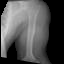

In [28]:
image = history_valid[3][8]

from PIL import Image
image = Image.fromarray(image)
image


# Saving of final reconstructed images 

In [10]:
# Create directory in models folder for reconstructed images
dataset_name = dataset_file_path.split('/')[-1]
reconstructed_images_path = model_file_path + "/" + dataset_name
if not path.exists(reconstructed_images_path):
    mkdir(reconstructed_images_path)

In [11]:
for x in range(len(history_valid)):
    fig, axs = plt.subplots(1,2, figsize=(8,4))
    axs[0].imshow(image_datasets['test'][x])
    axs[0].set_title('Original Image')
    new_image = np.floor(history_valid[0][x]).astype(np.uint8)
    axs[1].imshow(new_image)
    axs[1].set_title('Reconstructed Image')
    plt.savefig(f'{reconstructed_images_path}/Valid_Image_{x}.png')
    plt.close()
    break

NameError: name 'history_valid' is not defined

# Saving of Model Weights

In [12]:
model.save_weights(model_file_path + '/model_weights.h5')

ValueError: Unable to create dataset (name already exists)

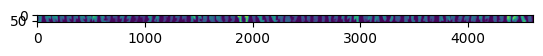

In [33]:
new_image = np.concatenate(history_valid[0], axis=1)
plt.imshow(new_image)

# GIF 


In [17]:
import re
from PIL import Image


In [13]:
def extract_epoch(filename):
    match = re.search(r'epoch_(\d+)', filename)
    if match:
        return int(match.group(1))
    return 0

def create_gif(folder_path, output_path, duration=50):
    images = []
    
    # Get all image file names from the folder
    filenames = os.listdir(folder_path)
    filenames = sorted(filenames, key=lambda x: extract_epoch(x))

    for filename in filenames:
        if filename.endswith('.png') or filename.endswith('.jpg'):
            file_path = os.path.join(folder_path, filename)
            image = Image.open(file_path).convert('P')
            images.append(image)
    
    # Save the images as a GIF
    images[0].save(output_path, save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=0)

In [18]:
gif_folder_path = model_file_path + "/" + "callback_images"
image_folders = ['image0', 'image1', 'image2']

for i,folder in enumerate(image_folders):
    curr_folder = gif_folder_path + "/" + folder
    gif_output_path = gif_folder_path + "/" + f"image{i}.gif"
    print(f"Creating GIF for: image{i}")
    create_gif(curr_folder, gif_output_path)

Creating GIF for: image0
Creating GIF for: image1
Creating GIF for: image2
